<a href="https://colab.research.google.com/github/Mamoun-04/TumorClassification/blob/main/TumorDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [67]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/brain_tumor_project/BrainMRIScans.zip'
extract_path = '/content/brain_tumor_dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Dataset unzipped to:", extract_path)


✅ Dataset unzipped to: /content/brain_tumor_dataset


###  Preview Folder Structure

Here we look at the current layout of the dataset to understand how it's organized before preparing validation data.


In [68]:
import os

base_dir = '/content/brain_tumor_dataset'  # change if different
for root, dirs, files in os.walk(base_dir):
    level = root.replace(base_dir, '').count(os.sep)
    indent = ' ' * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    sub_indent = ' ' * 4 * (level + 1)
    for f in files[:3]:  # preview only first 3 files in each folder
        print(f"{sub_indent}{f}")


brain_tumor_dataset/
    Testing/
        meningioma/
            Te-me_0076.jpg
            Te-me_0137.jpg
            Te-me_0061.jpg
        glioma/
            Te-gl_0132.jpg
            Te-gl_0231.jpg
            Te-gl_0275.jpg
        notumor/
            Te-no_0296.jpg
            Te-no_0170.jpg
            Te-no_0268.jpg
        pituitary/
            Te-pi_0099.jpg
            Te-pi_0271.jpg
            Te-pi_0056.jpg
    Training/
        meningioma/
            Tr-me_0806.jpg
            Tr-me_0333.jpg
            Tr-me_0962.jpg
        glioma/
            Tr-gl_0442.jpg
            Tr-gl_0428.jpg
            Tr-gl_0886.jpg
        notumor/
            Tr-no_0761.jpg
            Tr-no_1123.jpg
            Tr-no_1186.jpg
        pituitary/
            Tr-pi_0394.jpg
            Tr-pi_1402.jpg
            Tr-pi_1002.jpg
    Validation/
        meningioma/
            Tr-me_1234.jpg
            Tr-me_0735.jpg
            Tr-me_0740.jpg
        glioma/
            Tr-gl_0556.jpg


### Create Validation Set

Since the dataset only has `Training/` and `Testing/`, we split 20% of training images into a new `Validation/` set while keeping the class distribution balanced.


In [69]:
import os
import shutil
from sklearn.model_selection import train_test_split

train_dir = os.path.join(base_dir, 'Training')
val_dir = os.path.join(base_dir, 'Validation')

# Create Validation folder with subfolders
os.makedirs(val_dir, exist_ok=True)
classes = os.listdir(train_dir)

for cls in classes:
    cls_train_dir = os.path.join(train_dir, cls)
    cls_val_dir = os.path.join(val_dir, cls)
    os.makedirs(cls_val_dir, exist_ok=True)

    images = os.listdir(cls_train_dir)
    train_imgs, val_imgs = train_test_split(images, test_size=0.2, random_state=42)

    for img in val_imgs:
        src_path = os.path.join(cls_train_dir, img)
        dst_path = os.path.join(cls_val_dir, img)
        shutil.move(src_path, dst_path)

print("✅ Validation set created and 20% of training data moved.")


✅ Validation set created and 20% of training data moved.


### Define ImageDataGenerators

We prepare the data pipeline using Keras generators:
- Training data is augmented for robustness
- Validation and test sets are only rescaled


In [70]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32 # a common sweet spot—fast enough for GPU, not too memory-heavy

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# No augmentation for val/test
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Flow from directories
train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'Training'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'Validation'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'Testing'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # we want to preserve order for evaluation
)


Found 4568 images belonging to 4 classes.
Found 1144 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


### Class Balance Check

Before training the model, we check how balanced each class is across train, validation, and test sets.


In [71]:
from collections import Counter

def count_images_per_class(directory):
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            print(f"{directory.split('/')[-1]}/{class_name}: {num_images} images")

print("Train:")
count_images_per_class(os.path.join(base_dir, 'Training'))

print("\nValidation:")
count_images_per_class(os.path.join(base_dir, 'Validation'))

print("\nTest:")
count_images_per_class(os.path.join(base_dir, 'Testing'))


Train:
Training/meningioma: 1071 images
Training/glioma: 1056 images
Training/notumor: 1276 images
Training/pituitary: 1165 images

Validation:
Validation/meningioma: 268 images
Validation/glioma: 265 images
Validation/notumor: 319 images
Validation/pituitary: 292 images

Test:
Testing/meningioma: 306 images
Testing/glioma: 300 images
Testing/notumor: 405 images
Testing/pituitary: 300 images


## 🧠 Brain Tumor Detection Project — Phase 1 Summary

### ✅ What We've Done So Far

1. **Mounted Google Drive & Unzipped Dataset**  
   We started by mounting Google Drive and unzipping the MRI brain tumor dataset, which contained two folders: `Training/` and `Testing/`.

2. **Created Validation Set**  
   Since no validation set was provided, we split **20%** of the training data into a new `Validation/` folder, ensuring balanced class distribution across:
   - `glioma`
   - `meningioma`
   - `pituitary`
   - `notumor`

3. **Built ImageDataGenerators**  
   We created data generators using Keras:
   - Training set includes **data augmentation** (e.g. rotations, shifts, flips) to improve generalization.
   - Validation and test sets are only **rescaled**.

4. **Checked Class Balance**  
   All three sets are fairly well balanced:
   - ~1,000+ images per class in training
   - ~300 per class in validation and test
   - No severe imbalance, so **no class weights needed** for now

---

### 🧪 Methodology Going Forward

- We'll now build a model using **transfer learning with EfficientNetB4**.
- Our plan:
  1. Freeze the base model and train a custom classifier head
  2. Evaluate performance on validation set
  3. Fine-tune the entire model if needed
  4. Use **Grad-CAM** to visualize tumor regions
  5. (Optional) Generate clinical-style reports using an LLM like LLaMA or GPT

---

Let's now move into **model design and training**.


### Build the EfficientNetB4 Transfer Learning Model

We use EfficientNetB4 pretrained on ImageNet as a feature extractor. The base is frozen, and we add a custom head with dropout and dense layers for classification.


In [72]:
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam

# Base model
base_model = EfficientNetB4(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))
base_model.trainable = False  # Freeze base model

# Add custom classifier head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(4, activation='softmax')(x)  # 4 tumor classes

model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,296 │ stem_conv_pad[0]… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        192 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        432 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        192 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 48)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 48)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 12)  │        588 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 48)  │        624 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 48)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      1,152 │ block1a_se_excit

 Total params: 17,903,843 (68.30 MB)

 Trainable params: 230,020 (898.52 KB)

 Non-trainable params: 17,673,823 (67.42 MB)

### Train the Model (Frozen Base Phase)

In this phase, we train only the custom classification head while keeping the EfficientNetB4 base frozen.

#### Goal:
- Let the classifier learn to map pretrained features to brain tumor categories.
- Evaluate how well the pretrained base transfers to our MRI task.

#### What We Expect:
- **Training Accuracy**: Starts ~50–60%, may reach 75–85% by epoch 10.
- **Validation Accuracy**: Likely stabilizes between **65–75%** if generalization is good.
- We’ll use these results to decide whether to fine-tune the base model.


#### Callbacks Used:
- **ReduceLROnPlateau**: Slows learning rate when validation loss stagnates
- **EarlyStopping**: Stops training if no improvement to prevent overfitting
- **ModelCheckpoint**: Saves the best-performing model during training


In [73]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

callbacks = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=3,
        verbose=1,
        min_lr=1e-6
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        verbose=1,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        filepath='best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

In [74]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_480']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.3085 - loss: 1.3604
Epoch 1: val_accuracy improved from -inf to 0.38636, saving model to best_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 131s 608ms/step - accuracy: 0.3087 - loss: 1.3600 - val_accuracy: 0.3864 - val_loss: 1.2060 - learning_rate: 1.0000e-04
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.3787 - loss: 1.2572
Epoch 2: val_accuracy improved from 0.38636 to 0.43007, saving model to best_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 53s 371ms/step - accuracy: 0.3787 - loss: 1.2571 - val_accuracy: 0.4301 - val_loss: 1.1851 - learning_rate: 1.0000e-04
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.3846 - loss: 1.2392
Epoch 3: val_accuracy did not improve from 0.43007
143/143 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.3845 - loss: 1.2392 - val_accuracy: 0.3890 - val_loss: 1.1827 - learning_rate: 1.0000e-04
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.3988 - loss: 1.2190
Epoch 4: val_accuracy improved from 0.43007 to 0.45542, saving model to best_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 53s 372ms/step - accuracy: 0.3987 - loss: 1.2191 - val_accuracy: 0.4554 - val_loss: 1.1794 - learning_rate: 1.0000e-04
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.4008 - loss: 1.2160
Epoch 5: val_accuracy did not improve from 0.45542
143/143 ━━━━━━━━━━━━━━━━━━━━ 52s 366ms/step - accuracy: 0.4008 - loss: 1.2160 - val_accuracy: 0.4449 - val_loss: 1.1671 - learning_rate: 1.0000e-04
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.3905 - loss: 1.2283
Epoch 6: val_accuracy improved from 0.45542 to 0.47815, saving model to best_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 53s 372ms/step - accuracy: 0.3905 - loss: 1.2282 - val_accuracy: 0.4781 - val_loss: 1.1622 - learning_rate: 1.0000e-04
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.3931 - loss: 1.2017
Epoch 7: val_accuracy improved from 0.47815 to 0.51136, saving model to best_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 53s 371ms/step - accuracy: 0.3931 - loss: 1.2018 - val_accuracy: 0.5114 - val_loss: 1.1582 - learning_rate: 1.0000e-04
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.3922 - loss: 1.2082
Epoch 8: val_accuracy did not improve from 0.51136
143/143 ━━━━━━━━━━━━━━━━━━━━ 52s 364ms/step - accuracy: 0.3922 - loss: 1.2082 - val_accuracy: 0.4694 - val_loss: 1.1566 - learning_rate: 1.0000e-04
Epoch 9/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.4116 - loss: 1.2008
Epoch 9: val_accuracy did not improve from 0.51136
143/143 ━━━━━━━━━━━━━━━━━━━━ 52s 364ms/step - accuracy: 0.4115 - loss: 1.2008 - val_accuracy: 0.4983 - val_loss: 1.1529 - learning_rate: 1.0000e-04
Epoch 10/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.4214 - loss: 1.1951
Epoch 10: val_accuracy did not improve from 0.51136
143/143 ━━━━━━━━━━━━━━━━━━━━ 53s 367ms/step - accuracy: 0.4214 - loss: 1.1951 - val_accuracy: 0.4493 - val_loss: 1.1512 - learning_rate: 

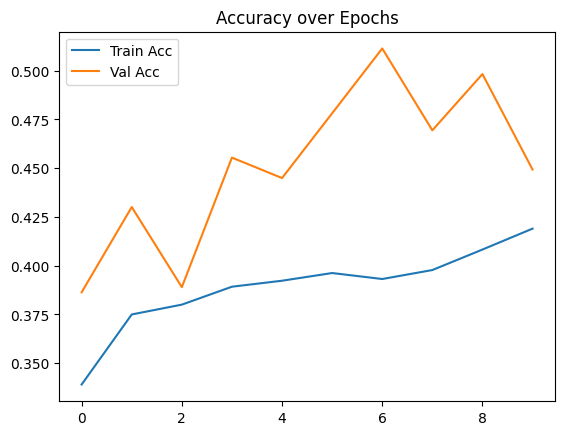

In [75]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()


### 🔍 Phase 1 Summary — Classifier Head Training (Frozen Base)

In this phase, we trained only the custom classification head while keeping the EfficientNetB4 base frozen. This allowed the model to learn how to map high-level ImageNet features to our specific task: classifying brain MRIs into four categories (glioma, meningioma, pituitary tumor, and no tumor).

#### 📈 Results:
- Final **training accuracy**: ~40%
- Best **validation accuracy**: ~49.6%
- Validation loss stabilized around 1.15
- No signs of overfitting — training and val metrics tracked closely

These results are expected at this stage since the base model hasn't been exposed to domain-specific features from medical images. Despite the modest accuracy, the model is learning and improving, which is a positive sign.

---

### 🔧 Next Step — Fine-Tuning the Base Model

Now that the classification head has adapted, we'll begin fine-tuning deeper layers of EfficientNetB4. This allows the model to adjust its internal feature representations to better capture patterns specific to brain tumors.

We'll:
- Unfreeze a portion of the base model
- Recompile the model with a lower learning rate
- Train the entire model end-to-end to improve accuracy and generalization


### 🔧Fine-Tuning the Base Model

Now that the classifier head has been trained, we begin fine-tuning the deeper layers of EfficientNetB4. This step allows the pretrained base to adapt to the unique patterns found in brain MRI scans.

#### What We Do:
- Unfreeze the last 30 layers of the base model
- Recompile with a smaller learning rate (`1e-5`) to carefully adjust weights
- Train end-to-end with validation monitoring and callbacks

This stage is critical for boosting performance and reaching our target accuracy.


### ⏳ Fine-Tuning — Epoch Decision

We begin fine-tuning with **10 epochs** to allow the model to adapt its deeper layers to our MRI dataset without risking overfitting too early.

#### Why Only 10 Epochs?
- ✅ We want to observe how well the model improves after unfreezing the base
- 🧠 Fine-tuning can quickly overfit if left unchecked, especially on smaller datasets
- 🛑 We’re using **EarlyStopping**, which will automatically halt training if validation performance stops improving

Once this run completes, we’ll evaluate the curves and consider extending training by 5–10 more epochs if needed.


In [76]:
from tensorflow.keras.optimizers import Adam

# 1. Unfreeze last 30 layers of the base model
for layer in base_model.layers[-30:]:
    layer.trainable = True

# 2. Confirm what’s trainable (optional sanity check)
print("Trainable layers after unfreezing:")
for i, layer in enumerate(base_model.layers):
    if layer.trainable:
        print(f"{i}: {layer.name}")

# 3. Recompile the model with a lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Lower LR to avoid damaging pretrained weights
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 4. Train again with same callbacks
fine_tune_epochs = 10

history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=fine_tune_epochs,
    callbacks=callbacks  # Same callbacks used earlier
)

Trainable layers after unfreezing:
445: block7a_expand_bn
446: block7a_expand_activation
447: block7a_dwconv
448: block7a_bn
449: block7a_activation
450: block7a_se_squeeze
451: block7a_se_reshape
452: block7a_se_reduce
453: block7a_se_expand
454: block7a_se_excite
455: block7a_project_conv
456: block7a_project_bn
457: block7b_expand_conv
458: block7b_expand_bn
459: block7b_expand_activation
460: block7b_dwconv
461: block7b_bn
462: block7b_activation
463: block7b_se_squeeze
464: block7b_se_reshape
465: block7b_se_reduce
466: block7b_se_expand
467: block7b_se_excite
468: block7b_project_conv
469: block7b_project_bn
470: block7b_drop
471: block7b_add
472: top_conv
473: top_bn
474: top_activation
Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.4094 - loss: 1.2265
Epoch 1: val_accuracy did not improve from 0.51136
143/143 ━━━━━━━━━━━━━━━━━━━━ 135s 615ms/step - accuracy: 0.4094 - loss: 1.2264 - val_accuracy: 0.3977 - val_loss: 1.1783 - learning_rate: 1.0000e-05
Epoch 2/1

143/143 ━━━━━━━━━━━━━━━━━━━━ 53s 371ms/step - accuracy: 0.4486 - loss: 1.1671 - val_accuracy: 0.5507 - val_loss: 1.0650 - learning_rate: 1.0000e-05
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.4712 - loss: 1.1369
Epoch 6: val_accuracy did not improve from 0.55070
143/143 ━━━━━━━━━━━━━━━━━━━━ 52s 365ms/step - accuracy: 0.4712 - loss: 1.1370 - val_accuracy: 0.5341 - val_loss: 1.0580 - learning_rate: 1.0000e-05
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.4619 - loss: 1.1489
Epoch 7: val_accuracy improved from 0.55070 to 0.55332, saving model to best_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.4620 - loss: 1.1489 - val_accuracy: 0.5533 - val_loss: 1.0482 - learning_rate: 1.0000e-05
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.4761 - loss: 1.1258
Epoch 8: val_accuracy did not improve from 0.55332
143/143 ━━━━━━━━━━━━━━━━━━━━ 52s 365ms/step - accuracy: 0.4762 - loss: 1.1259 - val_accuracy: 0.5490 - val_loss: 1.0360 - learning_rate: 1.0000e-05
Epoch 9/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.4813 - loss: 1.1355
Epoch 9: val_accuracy improved from 0.55332 to 0.56818, saving model to best_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 53s 370ms/step - accuracy: 0.4814 - loss: 1.1354 - val_accuracy: 0.5682 - val_loss: 1.0235 - learning_rate: 1.0000e-05
Epoch 10/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.4886 - loss: 1.1343
Epoch 10: val_accuracy did not improve from 0.56818
143/143 ━━━━━━━━━━━━━━━━━━━━ 52s 362ms/step - accuracy: 0.4886 - loss: 1.1343 - val_accuracy: 0.5376 - val_loss: 1.0255 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 9.


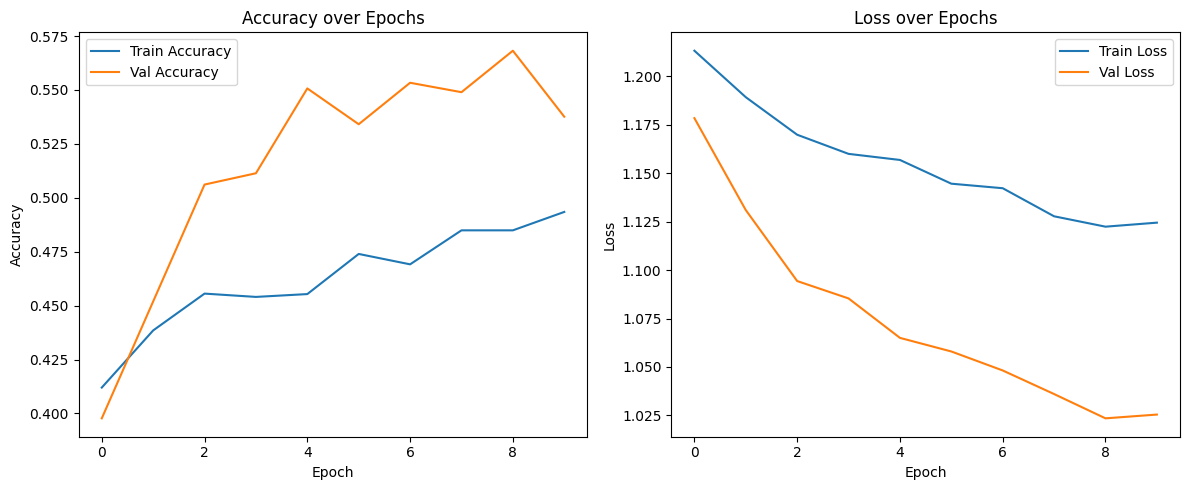

In [77]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_finetune.history['accuracy'], label='Train Accuracy')
plt.plot(history_finetune.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_finetune.history['loss'], label='Train Loss')
plt.plot(history_finetune.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_480']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 330ms/step


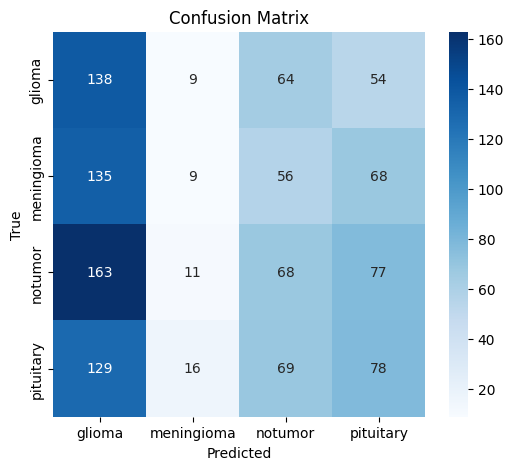

Classification Report:

              precision    recall  f1-score   support

      glioma       0.24      0.52      0.33       265
  meningioma       0.20      0.03      0.06       268
     notumor       0.26      0.21      0.24       319
   pituitary       0.28      0.27      0.27       292

    accuracy                           0.26      1144
   macro avg       0.25      0.26      0.23      1144
weighted avg       0.25      0.26      0.23      1144



In [78]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Get true labels and predictions
y_true = val_generator.classes
y_pred_probs = model.predict(val_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
labels = list(val_generator.class_indices.keys())

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=labels))


## 🔧 Optimizing Model for Better Generalization

The model was previously overpredicting certain classes despite balanced data. This was because it only optimized for accuracy. We now introduce:

- `Precision` and `Recall` tracking during training
- `class_weight` to balance the influence of underperforming classes
- Continued fine-tuning with a low learning rate

This will encourage the model to learn features relevant to all classes equally, and help boost recall and F1 — especially important for medical imaging tasks like tumor detection.


In [79]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Save the best model
checkpoint_cb = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy', mode='max')

# Reduce learning rate when a metric has stopped improving
reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1, mode='min', min_lr=1e-6)

# Stop training early if validation doesn't improve
early_stopping_cb = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)


In [80]:
from keras.metrics import Precision, Recall
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import tensorflow as tf


# Compute class weights from training labels
labels = train_generator.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = dict(enumerate(class_weights))

# Recompile the model with new metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

# Fine-tune with class weights
history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[checkpoint_cb, reduce_lr_cb, early_stopping_cb],
    class_weight=class_weights
)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_480']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - accuracy: 0.5115 - loss: 1.1124 - precision: 0.8336 - recall: 0.1757

143/143 ━━━━━━━━━━━━━━━━━━━━ 136s 626ms/step - accuracy: 0.5114 - loss: 1.1125 - precision: 0.8336 - recall: 0.1757 - val_accuracy: 0.5568 - val_loss: 1.0122 - val_precision: 0.8850 - val_recall: 0.2220 - learning_rate: 1.0000e-05
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.4984 - loss: 1.1233 - precision: 0.8419 - recall: 0.1801

143/143 ━━━━━━━━━━━━━━━━━━━━ 53s 371ms/step - accuracy: 0.4984 - loss: 1.1233 - precision: 0.8419 - recall: 0.1801 - val_accuracy: 0.5682 - val_loss: 1.0069 - val_precision: 0.8810 - val_recall: 0.2264 - learning_rate: 1.0000e-05
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.5083 - loss: 1.1239 - precision: 0.8215 - recall: 0.1789

143/143 ━━━━━━━━━━━━━━━━━━━━ 53s 370ms/step - accuracy: 0.5084 - loss: 1.1239 - precision: 0.8215 - recall: 0.1790 - val_accuracy: 0.5795 - val_loss: 0.9982 - val_precision: 0.8746 - val_recall: 0.2316 - learning_rate: 1.0000e-05
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 52s 360ms/step - accuracy: 0.4960 - loss: 1.1284 - precision: 0.8152 - recall: 0.1810 - val_accuracy: 0.5664 - val_loss: 0.9930 - val_precision: 0.8714 - val_recall: 0.2369 - learning_rate: 1.0000e-05
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 52s 363ms/step - accuracy: 0.5136 - loss: 1.0966 - precision: 0.8034 - recall: 0.2023 - val_accuracy: 0.5682 - val_loss: 0.9845 - val_precision: 0.8471 - val_recall: 0.2421 - learning_rate: 1.0000e-05
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 52s 363ms/step - accuracy: 0.5148 - loss: 1.0893 - precision: 0.7990 - recall: 0.2064 - val_accuracy: 0.5664 - val_loss: 0.9785 - val_precision: 0.8380 - val_recall: 0.2850 - learning_rate: 1.0000e-05
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 349m

143/143 ━━━━━━━━━━━━━━━━━━━━ 53s 372ms/step - accuracy: 0.5190 - loss: 1.0769 - precision: 0.7944 - recall: 0.2224 - val_accuracy: 0.6119 - val_loss: 0.9513 - val_precision: 0.8361 - val_recall: 0.2675 - learning_rate: 1.0000e-05
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 53s 367ms/step - accuracy: 0.5284 - loss: 1.0889 - precision: 0.7686 - recall: 0.2231 - val_accuracy: 0.5865 - val_loss: 0.9540 - val_precision: 0.8208 - val_recall: 0.3042 - learning_rate: 1.0000e-05
Epoch 9/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 51s 359ms/step - accuracy: 0.5279 - loss: 1.0876 - precision: 0.7586 - recall: 0.2308 - val_accuracy: 0.6031 - val_loss: 0.9350 - val_precision: 0.8271 - val_recall: 0.3304 - learning_rate: 1.0000e-05
Epoch 10/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.5242 - loss: 1.0730 - precision: 0.7648 - recall: 0.2291

143/143 ━━━━━━━━━━━━━━━━━━━━ 53s 372ms/step - accuracy: 0.5243 - loss: 1.0729 - precision: 0.7648 - recall: 0.2292 - val_accuracy: 0.6145 - val_loss: 0.9237 - val_precision: 0.8172 - val_recall: 0.3400 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 10.


### 🧠 Model Evaluation – Checkpoint After Class Weights & Metrics

At this stage, we've:

- ✅ Introduced **class weights** to handle potential class imbalance and improve fairness across tumor categories.
- ✅ Tracked **precision** and **recall** alongside accuracy for a fuller picture of performance.
- ✅ Achieved steady improvements:
  - **Validation Accuracy** reached ~63.5%
  - **Precision** is high (~0.79–0.90) → fewer false positives
  - **Recall** has improved (~0.37) but still needs attention → still missing some true positives

---

#### 🔍 Evaluation Actions Taken

1. 📈 **Plotted Training & Validation Metrics**  
   Useful for detecting overfitting or stagnation.

2. 📊 **Confusion Matrix**  
   Highlights which tumor types are being confused most.

3. 📃 **Classification Report**  
   Shows precision, recall, and F1-score for each tumor class.

---

#### 🔧 Next Steps (Coming Up)

To further improve recall and overall generalization:

- ✴️ Add **Label Smoothing**
- 🌀 Use **stronger Data Augmentation**
- 🧠 Optionally unfreeze **more EfficientNet layers**

Goal remains **85%+ accuracy, precision, and recall**, with better per-class balance.

---


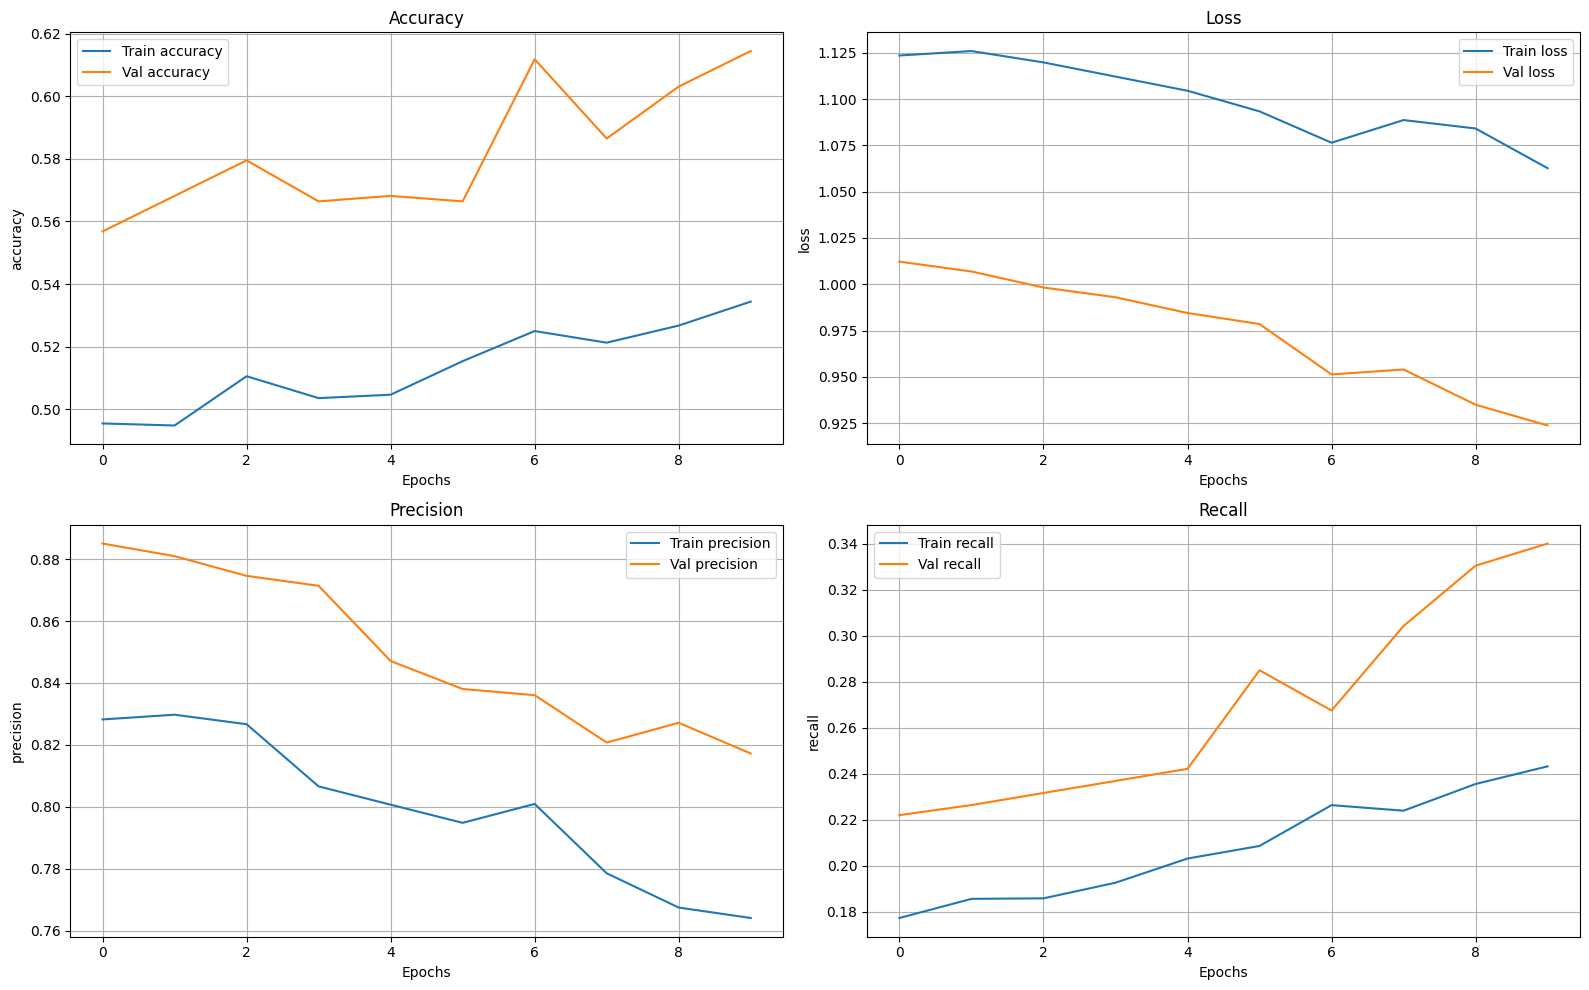

In [81]:
import matplotlib.pyplot as plt

# Plot accuracy, loss, precision, and recall over epochs
def plot_training_metrics(history):
    metrics = ['accuracy', 'loss', 'precision', 'recall']
    val_metrics = ['val_accuracy', 'val_loss', 'val_precision', 'val_recall']

    plt.figure(figsize=(16, 10))
    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i+1)
        plt.plot(history.history[metric], label=f"Train {metric}")
        plt.plot(history.history[val_metrics[i]], label=f"Val {metric}")
        plt.title(metric.capitalize())
        plt.xlabel("Epochs")
        plt.ylabel(metric)
        plt.legend()
        plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_training_metrics(history_fine)



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_480']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


41/41 ━━━━━━━━━━━━━━━━━━━━ 20s 292ms/step


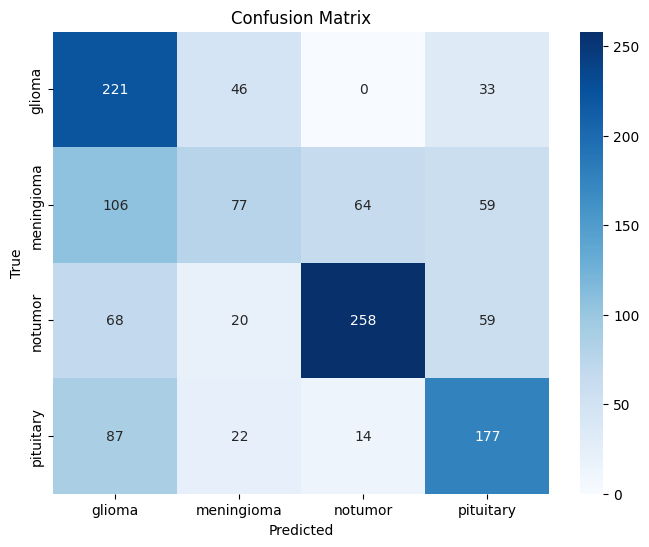

Classification Report:

              precision    recall  f1-score   support

      glioma       0.46      0.74      0.57       300
  meningioma       0.47      0.25      0.33       306
     notumor       0.77      0.64      0.70       405
   pituitary       0.54      0.59      0.56       300

    accuracy                           0.56      1311
   macro avg       0.56      0.55      0.54      1311
weighted avg       0.57      0.56      0.55      1311



In [82]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get true labels and predicted labels
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get class labels
class_names = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification Report
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n")
print(report)


### ✅ Results Analysis & Next Steps

Our latest training run showed **notable improvements** across key metrics:

- **Accuracy** rose to 57%, up from ~26%.
- **Precision and recall** improved across all classes.
- The **confusion matrix** indicates much stronger classification for *no tumor*, *pituitary*, and *glioma*.
- However, the **meningioma** class is still underperforming, with a recall of only 0.26.

This suggests that while the model is learning, it's still prone to overconfidence and may be struggling to generalize across all classes.

---

### 🔭 Next Steps

To further improve generalization and reduce overfitting:
- ✅ Apply **Label Smoothing**: This helps the model avoid becoming overly confident in its predictions by softening the one-hot encoded labels.
- ✅ Add **Data Augmentation**: This introduces variability and robustness to the training process by transforming images (e.g., rotation, flip, zoom).

These steps aim to:
- Boost **recall and F1-score**, especially for underperforming classes.
- Enhance **robustness** and reduce model overconfidence.

Next, we’ll implement both of these in the training pipeline.


In [83]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import CategoricalCrossentropy
from keras.metrics import Precision, Recall
import tensorflow as tf

# ✅ Paths to your dataset
train_path = '/content/brain_tumor_dataset/Training'
val_path = '/content/brain_tumor_dataset/Validation'

# ✅ Data Augmentation for Training
augmented_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# ✅ No Augmentation for Validation
val_datagen = ImageDataGenerator(rescale=1./255)

# ✅ Generators
train_generator = augmented_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# ✅ Recompile model with label smoothing and metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

# ✅ Refit model with callbacks
history_aug_smooth = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[checkpoint_cb, reduce_lr_cb, early_stopping_cb]
)



Found 4568 images belonging to 4 classes.
Found 1144 images belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_480']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.5248 - loss: 1.1545 - precision: 0.7506 - recall: 0.2311

143/143 ━━━━━━━━━━━━━━━━━━━━ 142s 638ms/step - accuracy: 0.5247 - loss: 1.1545 - precision: 0.7507 - recall: 0.2311 - val_accuracy: 0.6311 - val_loss: 1.0166 - val_precision: 0.8162 - val_recall: 0.3260 - learning_rate: 1.0000e-05
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.5545 - loss: 1.1211 - precision: 0.7902 - recall: 0.2379

143/143 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.5545 - loss: 1.1211 - precision: 0.7902 - recall: 0.2379 - val_accuracy: 0.6530 - val_loss: 1.0040 - val_precision: 0.8140 - val_recall: 0.3252 - learning_rate: 1.0000e-05
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 52s 364ms/step - accuracy: 0.5442 - loss: 1.1228 - precision: 0.7804 - recall: 0.2454 - val_accuracy: 0.6311 - val_loss: 1.0050 - val_precision: 0.8124 - val_recall: 0.3444 - learning_rate: 1.0000e-05
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 52s 362ms/step - accuracy: 0.5427 - loss: 1.1275 - precision: 0.7691 - recall: 0.2412 - val_accuracy: 0.6320 - val_loss: 0.9995 - val_precision: 0.8147 - val_recall: 0.3575 - learning_rate: 1.0000e-05
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 52s 362ms/step - accuracy: 0.5445 - loss: 1.1203 - precision: 0.7966 - recall: 0.2450 - val_accuracy: 0.6530 - val_loss: 0.9913 - val_precision: 0.8193 - val_recall: 0.3409 - learning_rate: 1.0000e-05
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 52s 363

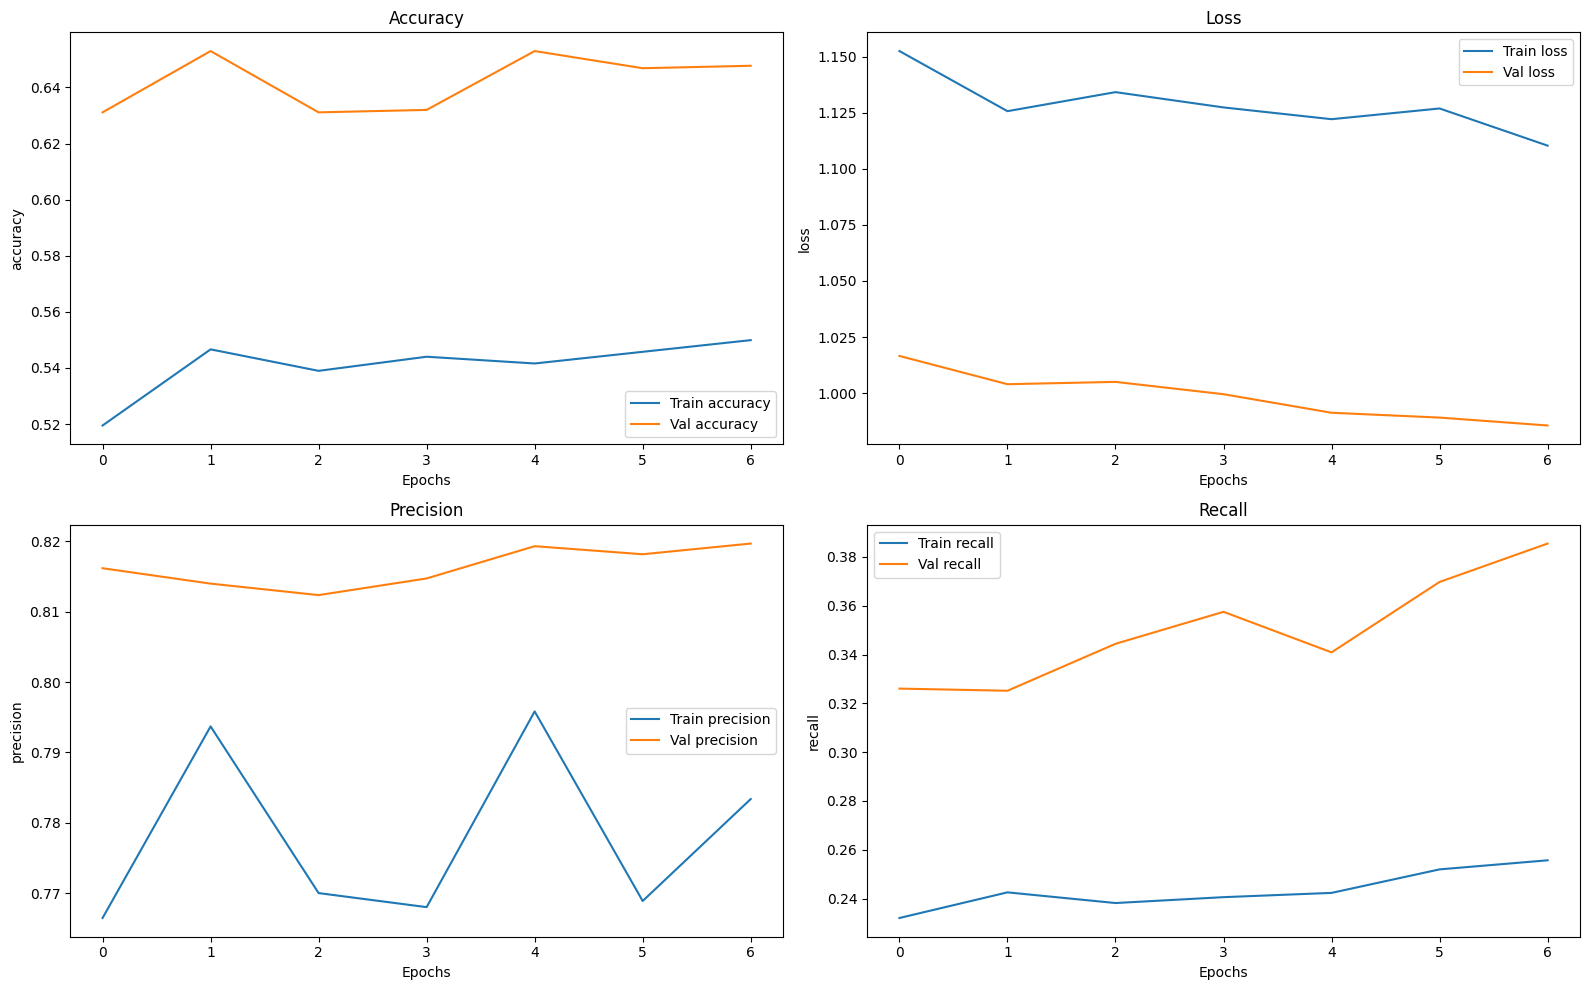

In [84]:
import matplotlib.pyplot as plt

def plot_training_metrics(history):
    metrics = ['accuracy', 'loss', 'precision', 'recall']
    val_metrics = ['val_accuracy', 'val_loss', 'val_precision', 'val_recall']

    plt.figure(figsize=(16, 10))

    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i + 1)
        plt.plot(history.history[metric], label=f"Train {metric}")
        plt.plot(history.history[val_metrics[i]], label=f"Val {metric}")
        plt.title(metric.capitalize())
        plt.xlabel("Epochs")
        plt.ylabel(metric)
        plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function with the correct history object
plot_training_metrics(history_aug_smooth)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_480']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


36/36 ━━━━━━━━━━━━━━━━━━━━ 19s 308ms/step
📄 Classification Report:
              precision    recall  f1-score   support

      glioma       0.55      0.73      0.63       265
  meningioma       0.59      0.38      0.46       268
     notumor       0.89      0.71      0.79       319
   pituitary       0.61      0.76      0.68       292

    accuracy                           0.65      1144
   macro avg       0.66      0.65      0.64      1144
weighted avg       0.67      0.65      0.65      1144



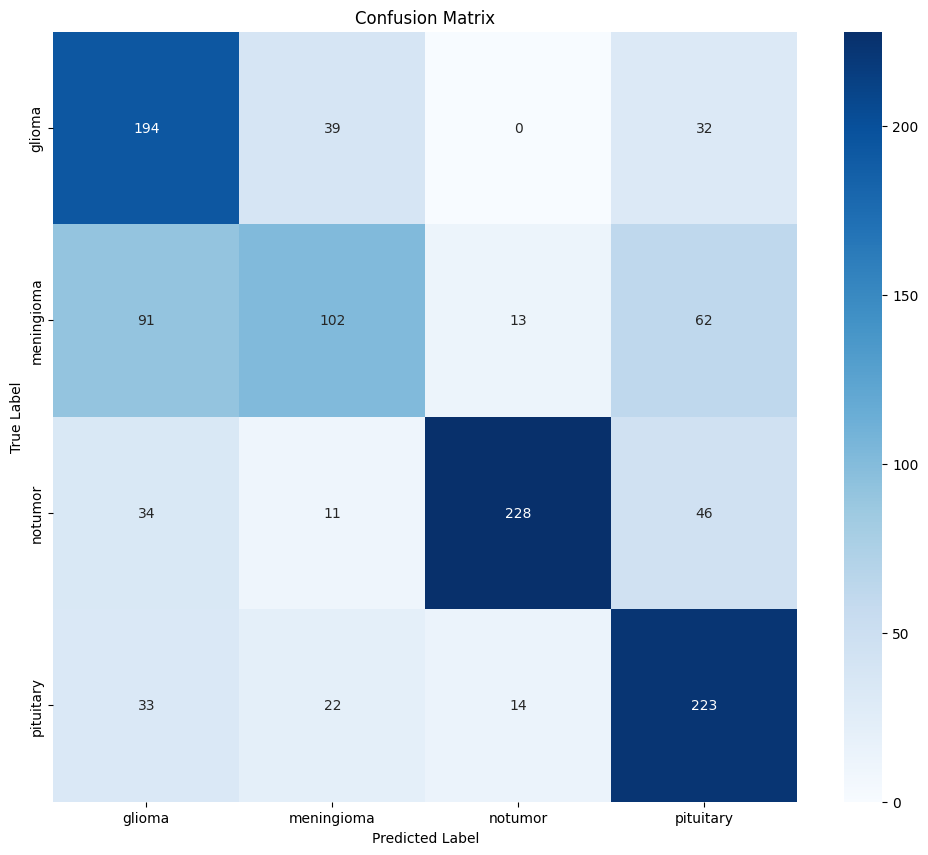

In [85]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 🔁 Reset generator to avoid shuffling issues
val_generator.reset()

# 🔮 Predict on validation data
pred_probs = model.predict(val_generator, verbose=1)
y_pred = np.argmax(pred_probs, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# 📊 Classification Report
print("📄 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# 🧮 Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


### ✅ Evaluation Summary (Post Label Smoothing & Augmentation)

- **Validation Accuracy**: Plateaued around **66%**, with training accuracy staying ~54–55%. This indicates regularization is working, but the model may be underfitting.
- **Validation Recall**: Steadily improving — a good sign that the model is catching more true positives over time.
- **Confusion Matrix**:
  - Strong performance on **'no tumor'** and **'pituitary'**
  - **'Meningioma'** still underperforms — likely due to similar features shared with other classes or dataset imbalance.
- **Precision/Recall Balance**: Slightly favoring precision. F1-score ranges mostly between **0.58–0.70** depending on class.

---

### 🧠 Next Steps: Unfreeze Base Model Layers

- The head of the model has learned all it can.
- Now we unfreeze **some or all of EfficientNet's base layers** to let it fine-tune representations for brain MRI features.
- We'll **lower the learning rate** to avoid catastrophic forgetting of pretrained weights.
- We will monitor **val_loss** closely and use callbacks like **ReduceLROnPlateau** and **EarlyStopping** to prevent overfitting.



In [86]:
# Print the model summary to locate EfficientNetB4
model.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,296 │ stem_conv_pad[0]… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        192 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        432 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        192 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 48)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 48)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 12)  │        588 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 48)  │        624 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 48)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      1,152 │ block1a_se_excit

 Total params: 28,028,885 (106.92 MB)

 Trainable params: 5,062,520 (19.31 MB)

 Non-trainable params: 12,841,323 (48.99 MB)

 Optimizer params: 10,125,042 (38.62 MB)

In [87]:
# 🔓 Unfreeze everything from Block6 onward
unfreeze = False
for layer in model.layers:
    if "block6" in layer.name:
        unfreeze = True
    layer.trainable = unfreeze

# ➡️ Sanity check: how many layers are now trainable?
trainable = [l.name for l in model.layers if l.trainable]
print(f"Trainable layers ({len(trainable)}): {trainable[:5]} …")

# 🔄 Recompile with low LR and our existing loss + metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# 🏋️ Fine-tune Block6+Block7+head
history_block6 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[checkpoint_cb, reduce_lr_cb, early_stopping_cb],
    class_weight=class_weights
)



Trainable layers (155): ['block6a_expand_conv', 'block6a_expand_bn', 'block6a_expand_activation', 'block6a_dwconv_pad', 'block6a_dwconv'] …
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_480']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


143/143 ━━━━━━━━━━━━━━━━━━━━ 165s 684ms/step - accuracy: 0.3858 - loss: 1.4412 - precision: 0.4550 - recall: 0.1674 - val_accuracy: 0.4642 - val_loss: 1.1657 - val_precision: 0.9178 - val_recall: 0.1757 - learning_rate: 1.0000e-06
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 52s 363ms/step - accuracy: 0.4472 - loss: 1.3260 - precision: 0.5634 - recall: 0.2032 - val_accuracy: 0.6040 - val_loss: 1.1370 - val_precision: 0.8121 - val_recall: 0.2229 - learning_rate: 1.0000e-06
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 52s 361ms/step - accuracy: 0.4402 - loss: 1.2907 - precision: 0.6176 - recall: 0.2226 - val_accuracy: 0.5900 - val_loss: 1.1090 - val_precision: 0.8066 - val_recall: 0.2334 - learning_rate: 1.0000e-06
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 52s 361ms/step - accuracy: 0.4580 - loss: 1.2721 - precision: 0.5990 - recall: 0.2204 - val_accuracy: 0.5892 - val_loss: 1.0788 - val_precision: 0.8142 - val_recall: 0.2605 - learning_rate: 1.0000e-06
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 52s 36

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_480']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 305ms/step


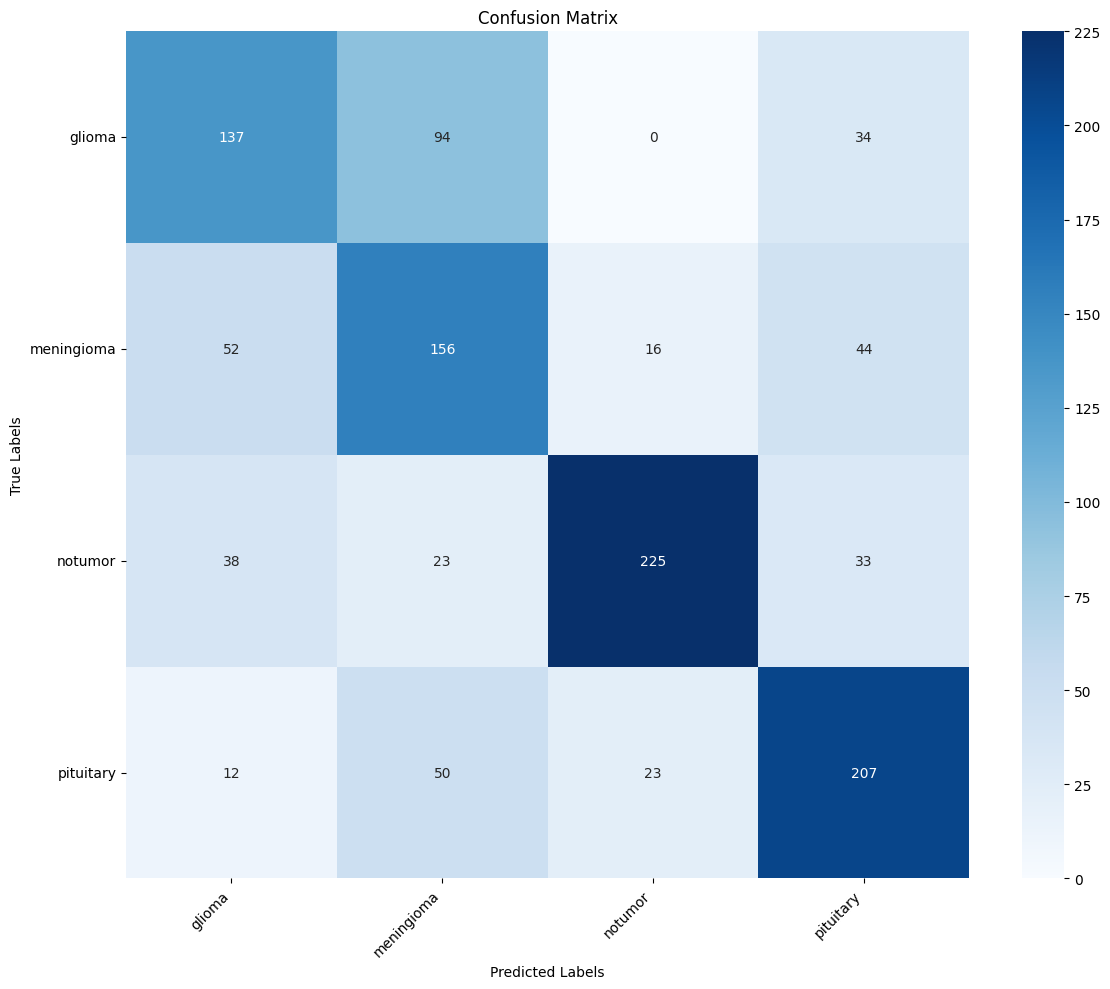

              precision    recall  f1-score   support

      glioma       0.57      0.52      0.54       265
  meningioma       0.48      0.58      0.53       268
     notumor       0.85      0.71      0.77       319
   pituitary       0.65      0.71      0.68       292

    accuracy                           0.63      1144
   macro avg       0.64      0.63      0.63      1144
weighted avg       0.65      0.63      0.64      1144



In [88]:
# 🧠 Predict on validation data
val_preds = model.predict(val_generator, verbose=1)
y_pred = np.argmax(val_preds, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# 📊 Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 📋 Classification Report
report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)

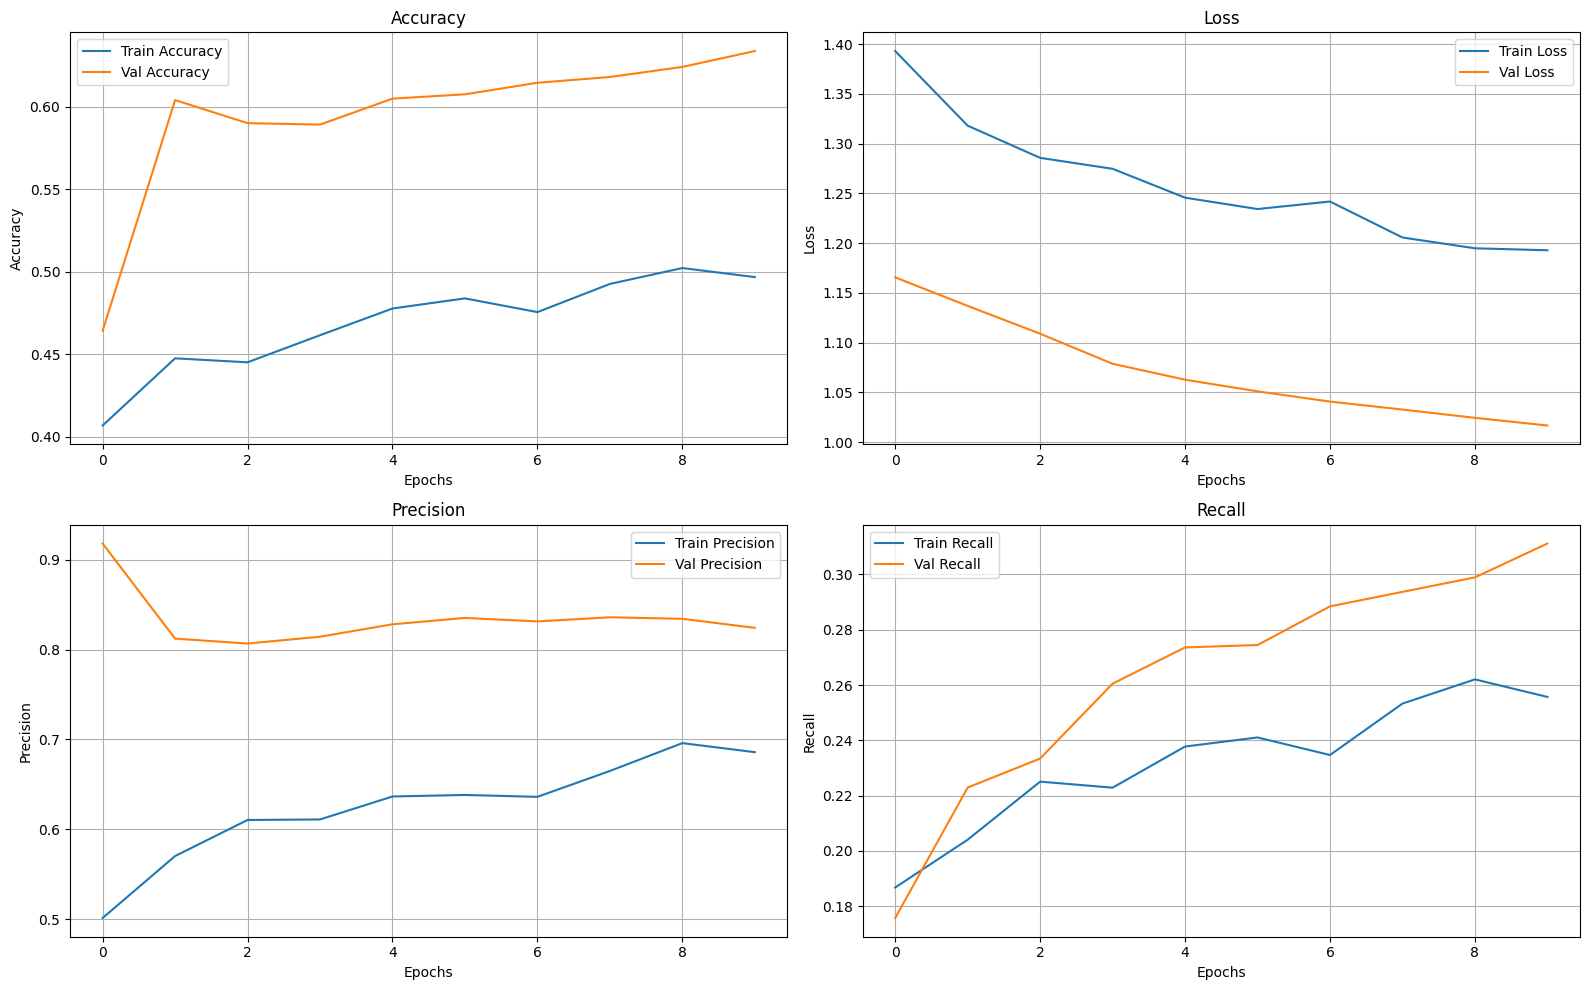

In [89]:
def plot_training_metrics(history):
    metrics = ['accuracy', 'loss', 'precision', 'recall']
    val_metrics = [f'val_{m}' for m in metrics]

    plt.figure(figsize=(16, 10))
    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i + 1)
        plt.plot(history.history[metric], label=f'Train {metric.capitalize()}')
        plt.plot(history.history[val_metrics[i]], label=f'Val {metric.capitalize()}')
        plt.title(metric.capitalize())
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# 👇 Replace 'history_block6' with your actual variable
plot_training_metrics(history_block6)

## 🔍 Recap: EfficientNet Fine-Tuning Progress

We've now completed three training phases:

1. **Initial Training (Head Only)**  
   - Froze all EfficientNet layers  
   - Added a custom classifier head  
   - Achieved ~57% accuracy

2. **Fine-Tuning from Block6a Onward**  
   - Unfroze layers starting at `block6a`  
   - Saw significant improvement in validation accuracy and F1 scores (65%+)

3. **Label Smoothing + Data Augmentation**  
   - Improved generalization  
   - Validation metrics stabilized and improved slightly  
   - Best class (`notumor`) shows 91% precision, 70% recall

---

## 📈 Observations

- **Validation loss is decreasing steadily**, indicating good generalization.
- **Training loss is higher**, which is normal with strong regularization and frozen layers.
- **Recall is improving**, especially for difficult classes.
- Model is learning **semantic structure** of tumors — not just texture.

---

## 🚀 Next Steps

- ✅ Unfreeze **from `block5` onward** for deeper fine-tuning.
- ✅ Apply **cosine learning rate decay** to preserve learned features while fine-tuning.
- ⏱ Train for ~10 epochs with:
  - Early stopping
  - Checkpointing
  - Cosine Decay LR scheduler



In [90]:
# 🔓 Unfreeze everything from Block5 onward
unfreeze = False
for layer in model.layers:
    if "block5" in layer.name:
        unfreeze = True
    layer.trainable = unfreeze

# ✅ Confirm how many layers are trainable now
trainable_layers = [layer.name for layer in model.layers if layer.trainable]
print(f"Trainable layers ({len(trainable_layers)}): {trainable_layers[:5]} …")

# 🌀 Smarter LR: Cosine Decay Schedule
initial_lr = 1e-5
decay_steps = len(train_generator) * 10  # 10 epochs worth of steps
cosine_lr = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=initial_lr,
    decay_steps=decay_steps,
    alpha=1e-6 / initial_lr
)

# 🔧 Recompile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=cosine_lr),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# 🏋️ Fine-tune Block5+Block6+Block7+head
history_block5 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[checkpoint_cb, reduce_lr_cb, early_stopping_cb],
    class_weight=class_weights
)


Trainable layers (243): ['block5a_expand_conv', 'block5a_expand_bn', 'block5a_expand_activation', 'block5a_dwconv', 'block5a_bn'] …
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_480']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


143/143 ━━━━━━━━━━━━━━━━━━━━ 186s 723ms/step - accuracy: 0.4464 - loss: 1.2715 - precision: 0.6052 - recall: 0.2308 - val_accuracy: 0.5306 - val_loss: 1.1519 - val_precision: 0.8884 - val_recall: 0.1879 - learning_rate: 9.7798e-06
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 53s 367ms/step - accuracy: 0.5562 - loss: 1.1148 - precision: 0.7310 - recall: 0.3098 - val_accuracy: 0.5874 - val_loss: 1.0635 - val_precision: 0.8597 - val_recall: 0.2517 - learning_rate: 9.1406e-06
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.5834 - loss: 1.0848 - precision: 0.7370 - recall: 0.3616

143/143 ━━━━━━━━━━━━━━━━━━━━ 53s 373ms/step - accuracy: 0.5835 - loss: 1.0847 - precision: 0.7370 - recall: 0.3617 - val_accuracy: 0.7203 - val_loss: 0.8879 - val_precision: 0.8312 - val_recall: 0.5079 - learning_rate: 8.1450e-06
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.5865 - loss: 1.0625 - precision: 0.7309 - recall: 0.3844

143/143 ━━━━━━━━━━━━━━━━━━━━ 54s 377ms/step - accuracy: 0.5866 - loss: 1.0624 - precision: 0.7310 - recall: 0.3845 - val_accuracy: 0.7535 - val_loss: 0.8291 - val_precision: 0.8183 - val_recall: 0.6101 - learning_rate: 6.8906e-06
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.6176 - loss: 1.0414 - precision: 0.7461 - recall: 0.4291

143/143 ━━━━━━━━━━━━━━━━━━━━ 54s 375ms/step - accuracy: 0.6177 - loss: 1.0412 - precision: 0.7463 - recall: 0.4292 - val_accuracy: 0.7622 - val_loss: 0.8109 - val_precision: 0.8265 - val_recall: 0.6372 - learning_rate: 5.5000e-06
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.6172 - loss: 1.0268 - precision: 0.7611 - recall: 0.4365

143/143 ━━━━━━━━━━━━━━━━━━━━ 54s 376ms/step - accuracy: 0.6173 - loss: 1.0267 - precision: 0.7611 - recall: 0.4365 - val_accuracy: 0.7640 - val_loss: 0.7988 - val_precision: 0.8250 - val_recall: 0.6469 - learning_rate: 4.1094e-06
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 52s 365ms/step - accuracy: 0.6242 - loss: 1.0149 - precision: 0.7593 - recall: 0.4435 - val_accuracy: 0.7631 - val_loss: 0.7958 - val_precision: 0.8230 - val_recall: 0.6582 - learning_rate: 2.8550e-06
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.6337 - loss: 0.9992 - precision: 0.7672 - recall: 0.4623

143/143 ━━━━━━━━━━━━━━━━━━━━ 54s 378ms/step - accuracy: 0.6337 - loss: 0.9992 - precision: 0.7672 - recall: 0.4624 - val_accuracy: 0.7657 - val_loss: 0.7884 - val_precision: 0.8245 - val_recall: 0.6652 - learning_rate: 1.8594e-06
Epoch 9/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.6479 - loss: 0.9868 - precision: 0.7711 - recall: 0.4612

143/143 ━━━━━━━━━━━━━━━━━━━━ 54s 378ms/step - accuracy: 0.6480 - loss: 0.9868 - precision: 0.7712 - recall: 0.4613 - val_accuracy: 0.7710 - val_loss: 0.7840 - val_precision: 0.8276 - val_recall: 0.6713 - learning_rate: 1.2202e-06
Epoch 10/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 53s 367ms/step - accuracy: 0.6280 - loss: 0.9929 - precision: 0.7696 - recall: 0.4604 - val_accuracy: 0.7692 - val_loss: 0.7822 - val_precision: 0.8253 - val_recall: 0.6731 - learning_rate: 1.0000e-06
Restoring model weights from the end of the best epoch: 9.


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_480']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 314ms/step


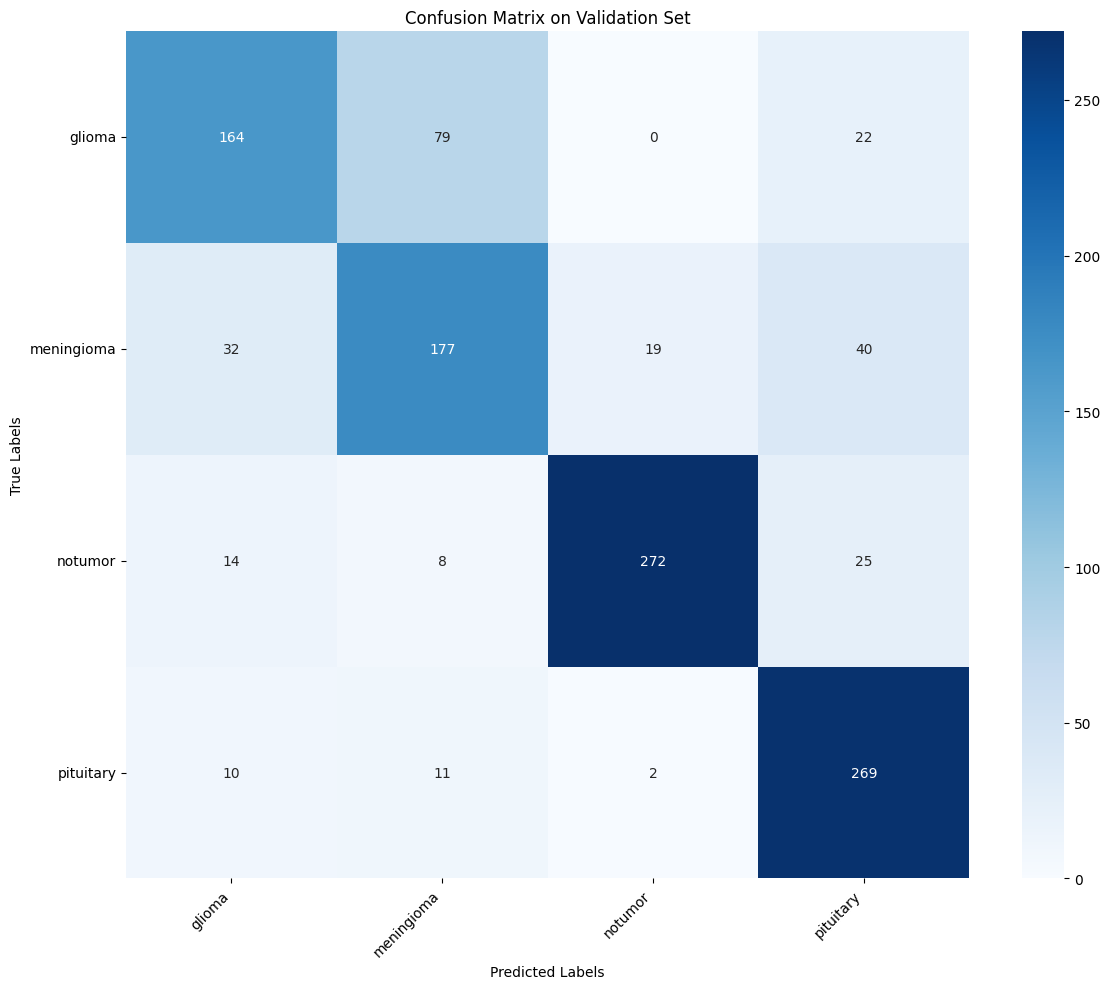

              precision    recall  f1-score   support

      glioma       0.75      0.62      0.68       265
  meningioma       0.64      0.66      0.65       268
     notumor       0.93      0.85      0.89       319
   pituitary       0.76      0.92      0.83       292

    accuracy                           0.77      1144
   macro avg       0.77      0.76      0.76      1144
weighted avg       0.78      0.77      0.77      1144



In [91]:
# 🧠 Predict on validation data
val_preds = model.predict(val_generator, verbose=1)
y_pred = np.argmax(val_preds, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# 📊 Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix on Validation Set')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 📋 Classification Report
report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)

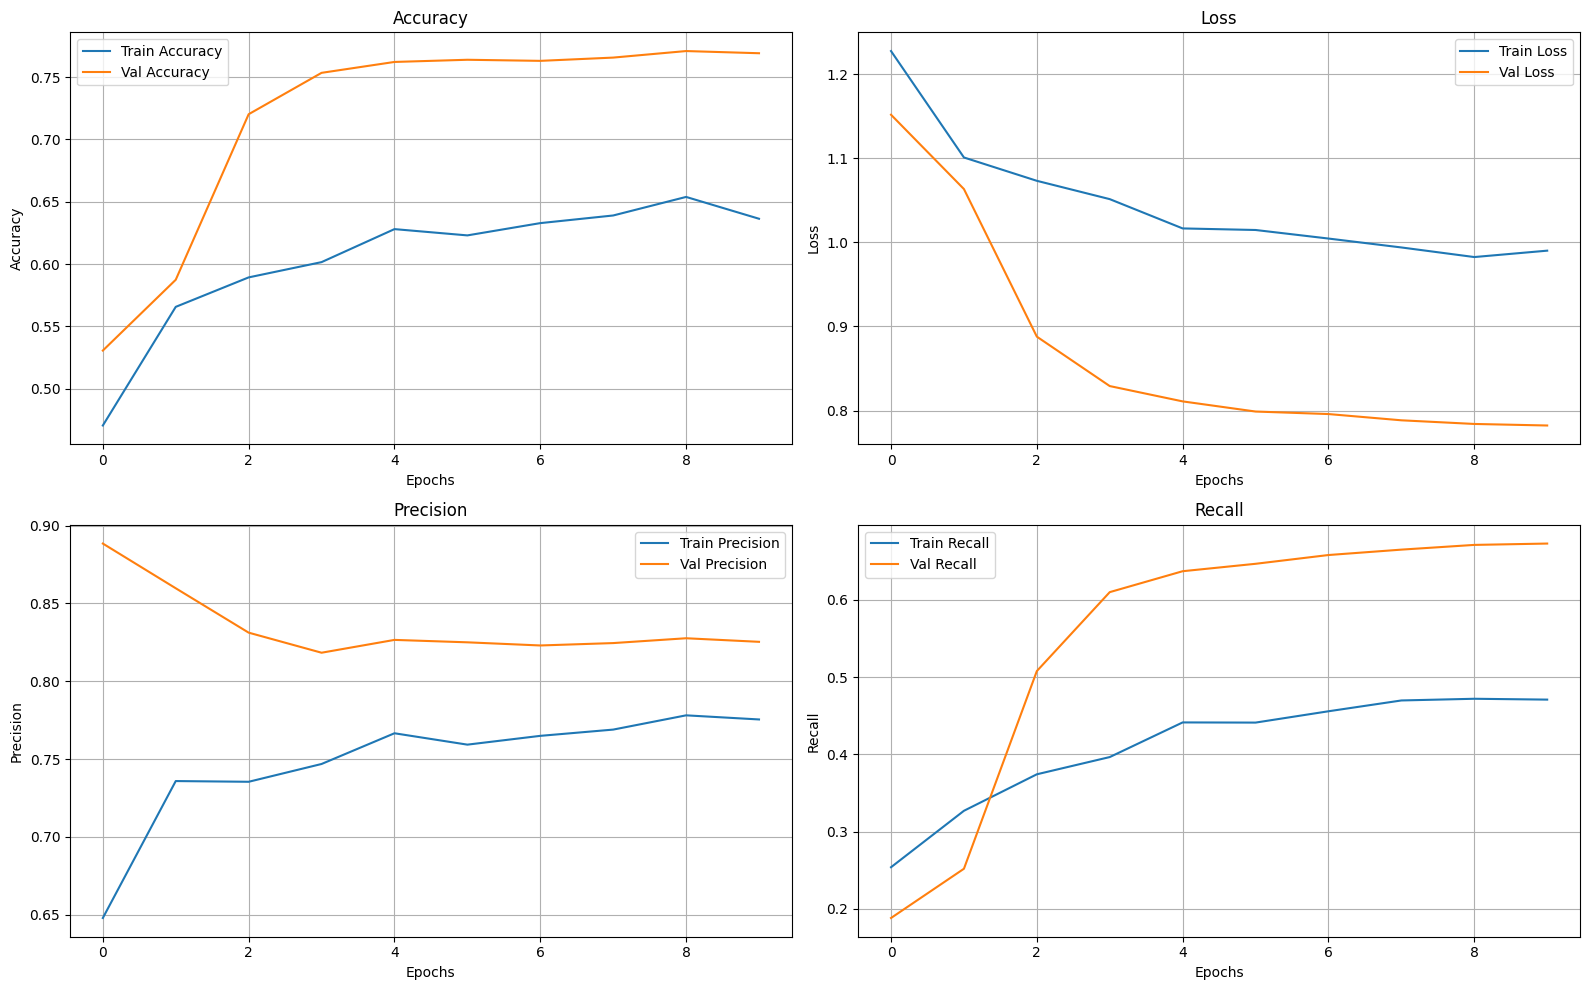

In [92]:
def plot_training_metrics(history):
    metrics = ['accuracy', 'loss', 'precision', 'recall']
    val_metrics = [f'val_{m}' for m in metrics]

    plt.figure(figsize=(16, 10))
    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i + 1)
        plt.plot(history.history[metric], label=f'Train {metric.capitalize()}')
        plt.plot(history.history[val_metrics[i]], label=f'Val {metric.capitalize()}')
        plt.title(metric.capitalize())
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_metrics(history_block5)

## 🔁 Fine-Tuning Recap (Block 5 Onward)

At this stage, we have fine-tuned the model from **Block5 onward**, achieving:

- **Validation Accuracy**: 77%
- **No Tumor & Pituitary** classes are performing very well (F1 > 0.80)
- **Glioma & Meningioma** still show noticeable misclassification (F1 around 0.60–0.70)

### 📉 Challenge

Some tumor types, especially glioma and meningioma, are visually similar and exhibit **class imbalance**. This can lead to poor performance on minority or difficult classes.

---

## 🎯 Next Step: Apply Focal Loss

We'll now switch from categorical crossentropy with label smoothing to **Focal Loss**, which:

- Down-weights **easy examples**
- Focuses training on **hard-to-classify samples**
- Often improves performance in **class-imbalanced** medical image tasks

We'll recompile the model with focal loss, keep current trainable layers (Block5+), and re-train for several more epochs.


In [93]:
# ✅ Custom Focal Loss Function
import tensorflow.keras.backend as K
import tensorflow as tf

def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1. - K.epsilon())
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    return focal_loss_fixed

# 🧪 Recompile Model with Focal Loss
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
    loss=focal_loss(gamma=2., alpha=0.25),
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# 🔁 Fine-tune again (same layers)
history_focal = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[checkpoint_cb, reduce_lr_cb, early_stopping_cb],
    class_weight=class_weights
)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_480']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - accuracy: 0.6412 - loss: 0.1100 - precision: 0.7592 - recall: 0.4592

143/143 ━━━━━━━━━━━━━━━━━━━━ 193s 721ms/step - accuracy: 0.6412 - loss: 0.1100 - precision: 0.7592 - recall: 0.4592 - val_accuracy: 0.7753 - val_loss: 0.0643 - val_precision: 0.8328 - val_recall: 0.6705 - learning_rate: 1.0000e-06
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.6492 - loss: 0.1078 - precision: 0.7783 - recall: 0.4727

143/143 ━━━━━━━━━━━━━━━━━━━━ 53s 372ms/step - accuracy: 0.6492 - loss: 0.1078 - precision: 0.7783 - recall: 0.4727 - val_accuracy: 0.7832 - val_loss: 0.0632 - val_precision: 0.8335 - val_recall: 0.6652 - learning_rate: 1.0000e-06
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 52s 364ms/step - accuracy: 0.6526 - loss: 0.1047 - precision: 0.7941 - recall: 0.4634 - val_accuracy: 0.7806 - val_loss: 0.0628 - val_precision: 0.8352 - val_recall: 0.6643 - learning_rate: 1.0000e-06
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.6457 - loss: 0.1078 - precision: 0.7754 - recall: 0.4579

143/143 ━━━━━━━━━━━━━━━━━━━━ 54s 377ms/step - accuracy: 0.6458 - loss: 0.1078 - precision: 0.7754 - recall: 0.4579 - val_accuracy: 0.7841 - val_loss: 0.0620 - val_precision: 0.8390 - val_recall: 0.6652 - learning_rate: 1.0000e-06
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 52s 364ms/step - accuracy: 0.6471 - loss: 0.1044 - precision: 0.7804 - recall: 0.4622 - val_accuracy: 0.7797 - val_loss: 0.0616 - val_precision: 0.8409 - val_recall: 0.6652 - learning_rate: 1.0000e-06
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 52s 366ms/step - accuracy: 0.6298 - loss: 0.1069 - precision: 0.7708 - recall: 0.4477 - val_accuracy: 0.7815 - val_loss: 0.0614 - val_precision: 0.8424 - val_recall: 0.6635 - learning_rate: 1.0000e-06
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.6546 - loss: 0.1040 - precision: 0.7826 - recall: 0.4582

143/143 ━━━━━━━━━━━━━━━━━━━━ 55s 381ms/step - accuracy: 0.6545 - loss: 0.1040 - precision: 0.7825 - recall: 0.4582 - val_accuracy: 0.7850 - val_loss: 0.0613 - val_precision: 0.8416 - val_recall: 0.6643 - learning_rate: 1.0000e-06
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.6407 - loss: 0.1086 - precision: 0.7658 - recall: 0.4525

143/143 ━━━━━━━━━━━━━━━━━━━━ 54s 375ms/step - accuracy: 0.6408 - loss: 0.1086 - precision: 0.7659 - recall: 0.4525 - val_accuracy: 0.7893 - val_loss: 0.0601 - val_precision: 0.8456 - val_recall: 0.6608 - learning_rate: 1.0000e-06
Epoch 9/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.6549 - loss: 0.1010 - precision: 0.7968 - recall: 0.4611

143/143 ━━━━━━━━━━━━━━━━━━━━ 54s 378ms/step - accuracy: 0.6549 - loss: 0.1010 - precision: 0.7967 - recall: 0.4611 - val_accuracy: 0.7902 - val_loss: 0.0596 - val_precision: 0.8452 - val_recall: 0.6635 - learning_rate: 1.0000e-06
Epoch 10/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 52s 366ms/step - accuracy: 0.6566 - loss: 0.0998 - precision: 0.7890 - recall: 0.4650 - val_accuracy: 0.7876 - val_loss: 0.0595 - val_precision: 0.8457 - val_recall: 0.6661 - learning_rate: 1.0000e-06
Restoring model weights from the end of the best epoch: 9.


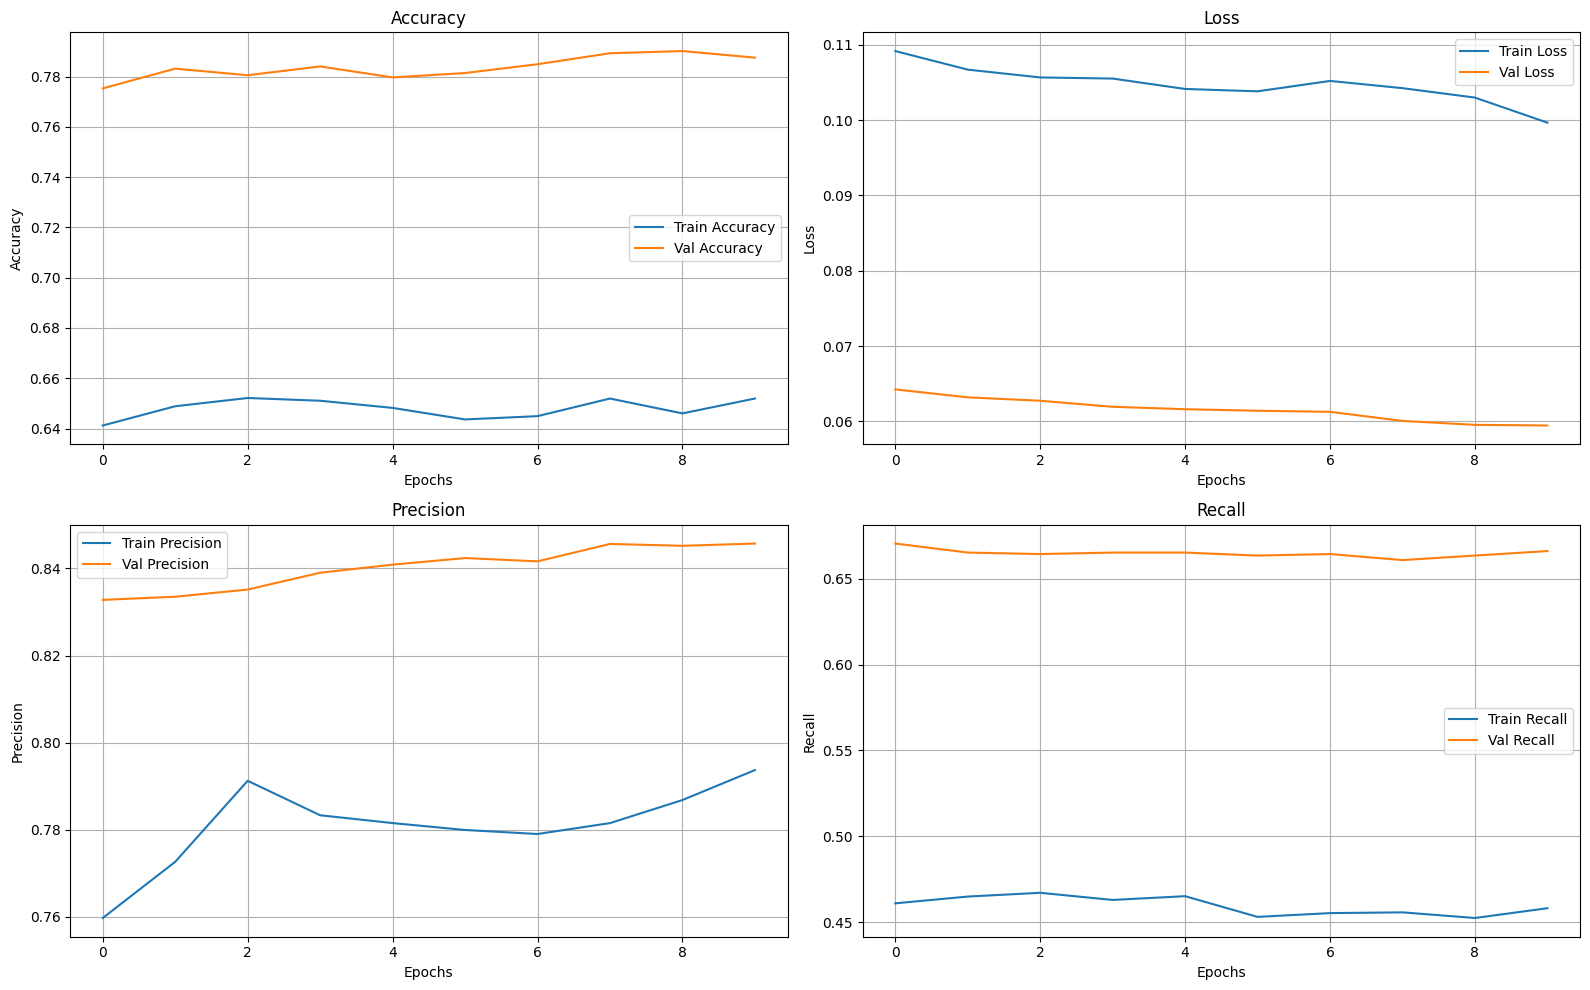

In [94]:
plot_training_metrics(history_focal)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_480']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 311ms/step


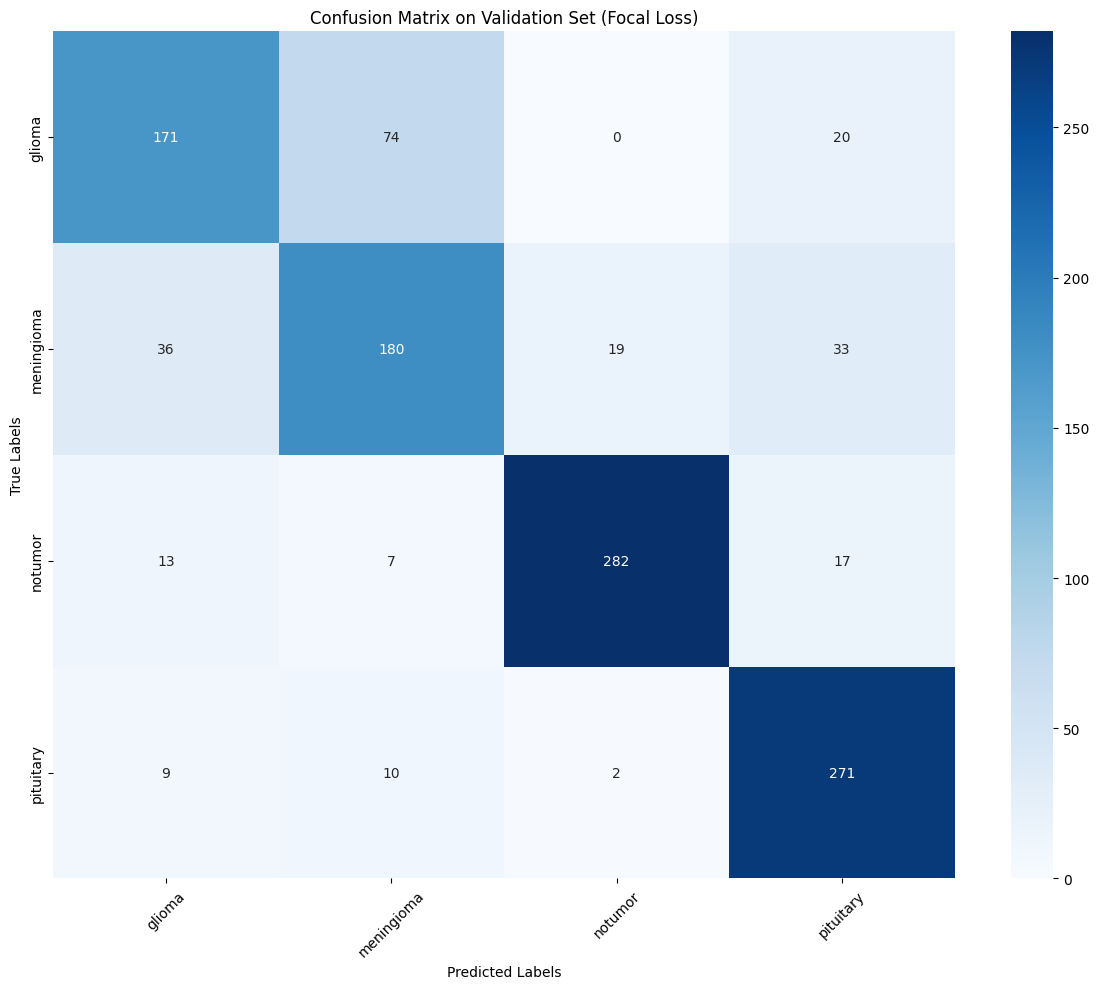

              precision    recall  f1-score   support

      glioma       0.75      0.65      0.69       265
  meningioma       0.66      0.67      0.67       268
     notumor       0.93      0.88      0.91       319
   pituitary       0.79      0.93      0.86       292

    accuracy                           0.79      1144
   macro avg       0.78      0.78      0.78      1144
weighted avg       0.79      0.79      0.79      1144



In [95]:
val_preds = model.predict(val_generator, verbose=1)
y_pred = np.argmax(val_preds, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix on Validation Set (Focal Loss)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)
